In [1]:
class_names = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
        'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
        'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
        'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
        'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
        'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
        'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
        'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear',
        'hair drier', 'toothbrush'] 

In [2]:
import torch
import torch.nn.functional as F
from PIL import Image
import numpy as np
from local_yolos.yolov5.models.experimental import attempt_load
from local_yolos.yolov5.utils.general import non_max_suppression
from torchvision import transforms
from local_yolos.yolov5.utils.metrics import box_iou
from local_yolos.yolov5.utils.plots import Annotator, colors
import time
from tqdm import tqdm
import os
import random
from datasets.augmentations1 import train_transform
from datasets.split_data_set_combined import SplitDatasetCombined_BDD
from attacks_tools.yolov8_wrapper import CustomPredictor
from pathlib import Path
import csv

/Users/coenschoof/miniconda/envs/phantomsponges/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
print("Starting script", flush=True)
model_name = 'yolov5'
model_size = 's'
seed = 42
img_size=(640,640)
batch_size = 8
max_labels_per_img = 65
IMG_DIR = '/Users/coenschoof/miniconda/envs/phantomsponges/BDD100K-to-YOLOV5/bdd_in_YOLOV5_train_newLabels/images/val'
LAB_DIR = '/Users/coenschoof/miniconda/envs/phantomsponges/BDD100K-to-YOLOV5/bdd_in_YOLOV5_train_newLabels/labels/val'
experiment_dir = '/Users/coenschoof/miniconda/envs/phantomsponges/PhantomSponges/experiments/sample_experiment/'
patch_file = experiment_dir + 'final_results/final_patch.png'
aspect_ratios = [(1.5, 2, 'width'), (0.7, 0.85, 'height'), (0.6, 0.75, 'both')] 

dir_names = []
Path(experiment_dir + '/evaluation').mkdir(parents=True, exist_ok=False)
for ar in aspect_ratios:
    dir_name = f"range_scaling=({ar[0]},{ar[1]})_dimension={ar[2]}"
    Path(experiment_dir + '/evaluation/' + dir_name).mkdir(parents=True, exist_ok=False)
    dir_names.append(dir_name)

Path(experiment_dir + '/evaluation/no_dimension_scaling').mkdir(parents=True, exist_ok=False)
dir_names.append('no_dimension_scaling')
aspect_ratios.append('no_dimension_scaling')

# Path(experiment_dir + '/evaluation/no_perturbation').mkdir(parents=True, exist_ok=False)
# dir_names.append('no_perturbation')
# aspect_ratios.append('no_perturbation')

Starting script


In [5]:
def collate_fn(batch):
    return tuple(zip(*batch))

def set_random_seed(seed_value, use_cuda=True):
    np.random.seed(seed_value)  # cpu vars
    torch.manual_seed(seed_value)  # cpu  vars
    random.seed(seed_value)  # Python
    os.environ['PYTHONHASHSEED'] = str(seed_value)  # Python hash buildin
    if use_cuda:
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)  # gpu vars
        torch.backends.cudnn.deterministic = True  # needed
        torch.backends.cudnn.benchmark = False

In [6]:
split_dataset = SplitDatasetCombined_BDD(
            img_dir= IMG_DIR,
            lab_dir= LAB_DIR,
            max_lab=max_labels_per_img,
            img_size=img_size,
            transform=train_transform,
            collate_fn=collate_fn)

train_loader, val_loader, test_loader = split_dataset(val_split=0.1,
                                                      shuffle_dataset=True,
                                                      random_seed=seed,
                                                      batch_size=batch_size,
                                                      ordered=False,
                                                      collate_fn=collate_fn)

In [7]:
#model = attempt_load(weights=pt_file).eval()
#model = attempt_load_weights('yolov8n.pt', device=torch.device('cuda'), inplace=True, fuse=True).to('cuda')

#model = CustomPredictor(overrides = dict(model='yolov8n.pt'))
#model = CustomPredictor(weights='local_yolos/yolov5/weights/yolov5s.pt').to('cpu')


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
if model_name == 'yolov8':
    from local_yolos.yolov8.ultralytics.nn.tasks import attempt_load_weights
    from attacks_tools.yolov8_wrapper import CustomDetectionModelWrapper
    pt_file = model_name + model_size + '.pt' 
    model = attempt_load_weights(weights='local_yolos/yolov8/weights/' + pt_file, device=device, inplace=True, fuse=True)
    model = CustomDetectionModelWrapper(model)
if model_name == 'yolov5':
    # taken from https://github.com/ultralytics/yolov5
    from local_yolos.yolov5.models.experimental import attempt_load
    pt_file = model_name + model_size + '.pt'
    model = attempt_load('local_yolos/yolov5/weights/' + pt_file, device).eval()
elif model_name == 'yolov4':
    # taken from https://github.com/WongKinYiu/PyTorch_YOLOv4
    from local_yolos.yolov4.models.models import Darknet, load_darknet_weights
    model = Darknet('local_yolos/yolov4/cfg/yolov4.cfg', img_size=640).to(device).eval()
    load_darknet_weights(model, 'local_yolos/yolov4/weights/yolov4.weights')
elif model_name == 'yolov3':
    # taken from https://github.com/ultralytics/yolov3
    from local_yolos.yolov3 import hubconf
    model = hubconf.yolov3(pretrained=True, autoshape=False, device=device)


Fusing layers... 


local_yolos/yolov5/weights/yolov5s.pt


[W NNPACK.cpp:79] Could not initialize NNPACK! Reason: Unsupported hardware.
yolov5s summary: 270 layers, 7235389 parameters, 0 gradients, 16.6 GFLOPs


In [8]:
def perturb_img(img_name, aspect_ratio = None, output_type = "torch"):
    image_path = IMG_DIR + "/" + img_name
    image = Image.open(image_path)
    image = image.resize((640, 640))
    transform = transforms.Compose([transforms.ToTensor()])
    clean_img = transform(image)

    # Load the image using PIL
    #patch_path =  "/home/cschoof/experiments/yolov_5_epsilon=30_lambda1=0.6_lambda2=10/final_results/final_patch.png"
    patch_path = patch_file
    patch = Image.open(patch_path)
    patch = transform(patch)

    perturbed_img = torch.clamp(clean_img + patch, 0, 1)

    # Assuming you have a torch tensor named torch_image
    # You can resize the tensor to (H, W, C) shape using transpose and multiply by 255 (if it's not already in the correct range)
    #pil_image = transforms.ToPILImage()(result.squeeze().cpu() * 255)
    tensor_min = torch.min(perturbed_img)
    tensor_max = torch.max(perturbed_img)
    normalized_tensor = (perturbed_img - tensor_min) / (tensor_max - tensor_min)

    # Convert the normalized tensor to a PIL image
    pil_image = transforms.ToPILImage()(normalized_tensor.squeeze().cpu())
    random_scale_w = 1
    random_scale_h = 1

    if type(aspect_ratio) == tuple:
        if aspect_ratio[2] == 'width':
            random_scale_w = random.uniform(aspect_ratio[0], aspect_ratio[1])
        elif aspect_ratio[2] == 'height':
            random_scale_h = random.uniform(aspect_ratio[0], aspect_ratio[1])
        elif aspect_ratio[2] == 'both':
            random_scale_w = random.uniform(aspect_ratio[0], aspect_ratio[1])
            random_scale_h = random.uniform(aspect_ratio[0], aspect_ratio[1])
            

    width = int(640 * random_scale_w)
    width = (width // 32) * 32 #ensures that the new width is a multiple of 32, otherwise the model does not work
    height = int(640 * random_scale_h)
    height = (height // 32) * 32
    pil_image = pil_image.resize((width, height))

    if output_type == "torch":
        perturbed_image = transform(pil_image)
    elif output_type == "numpy":
        perturbed_image = np.array(pil_image)
    elif output_type == "pil":
        pass
    else:
        print("Unsupported output type provided!")

    return(perturbed_image)


In [9]:
def compute_recall(box_iou_output):
    true_pos = 0
    for clean_detection in box_iou_output:
        if clean_detection[clean_detection > 0.45].nelement() != 0:
            true_pos += 1

    return true_pos / box_iou_output.size()[0]

In [10]:
def add_bbs_new(image, xyxys, numbered_labels):
    numpy_clean_img = image.squeeze().permute(1, 2, 0).cpu().numpy()
    annotator = Annotator(np.ascontiguousarray(numpy_clean_img))
    str_labels = [class_names[int(class_idx)] for class_idx in numbered_labels]
    
    for xyxy, box_label, numbered_labels in zip(xyxys, str_labels, numbered_labels):
        annotator.box_label(xyxy, box_label, colors(numbered_labels, True)) #label, color=colors(c, True)
    annotator_results = annotator.result()
    annotator_results = (annotator_results * 255).astype(np.uint8)
    pil_image = Image.fromarray(annotator_results)

    return pil_image

In [11]:
def add_bbs(image, xyxys):
    numpy_clean_img = image.squeeze().permute(1, 2, 0).cpu().numpy()
    annotator = Annotator(np.ascontiguousarray(numpy_clean_img))
    
    for xyxy in xyxys:
        annotator.box_label(xyxy)
    annotator_results = annotator.result()
    annotator_results = (annotator_results * 255).astype(np.uint8)
    pil_image = Image.fromarray(annotator_results)

    return pil_image

In [12]:
def scale_bbs(orig_dims, target_dims, orig_xyxy):
    # Original image dimensions (640x1200)
    original_height, original_width = orig_dims[2:]

    # Target image dimensions (640x640)
    target_height, target_width = target_dims[2:]

    # Calculate scaling factors for x and y dimensions
    x_scale = target_width / original_width
    y_scale = target_height / original_height

    # Scale the coordinates of the bounding boxes
    scaled_bounding_boxes = orig_xyxy.clone().detach()  # Create a copy to preserve the original data
    scaled_bounding_boxes[:, 0] *= x_scale  # Scale x (left)
    scaled_bounding_boxes[:, 1] *= y_scale  # Scale y (top)
    scaled_bounding_boxes[:, 2] *= x_scale  # Scale x2 (right)
    scaled_bounding_boxes[:, 3] *= y_scale  # Scale y2 (bottom)

    return scaled_bounding_boxes

In [11]:
# def evaluate_results(loader = test_loader, Tconf = 0.25, Tiou = 0.45, max_det_pert=300, max_det_clean=300, save_png_interval = 25):
#     results_for_all_aspect_ratios = []
#     for aspect_ratio, dir_name in zip(aspect_ratios, dir_names):
#         print(dir_name)

#         all_total_times = []
#         all_nms_times = []
#         all_num_bbs_before_nms = []
#         all_recalls = []
#         results_for_single_aspect_ratio_dir = dir_name

#         for idx, (image_np, _, image_name) in tqdm(enumerate(loader)):
#             # if idx == 50:
#             #     break
#             if dir_name != 'no_perturbation':
#                 perturbed_img = perturb_img(image_name[0], aspect_ratio=aspect_ratio).unsqueeze(0) 
#             else:
#                 print("else statement")
#                 perturbed_img = image_np[0].unsqueeze(0)
#             clean_img = image_np[0].unsqueeze(0)

#             total_times_single_img = []
#             nms_times_single_img = []

#             for i in range(1):
#                 start_time_1 = time.time() * 1000
#                 output_perturbed = model(perturbed_img)[0]
#                 start_time_2 = time.time() * 1000
#                 keep_perturbed = non_max_suppression(output_perturbed, Tconf, Tiou, classes=None,max_det=max_det_pert)
#                 #print(len(keep_perturbed[0]))
#                 end_time = time.time() * 1000 
#                 total_time = end_time - start_time_1
#                 nms_time = end_time - start_time_2
#                 total_times_single_img.append(total_time)
#                 nms_times_single_img.append(nms_time)
            
#             total_time = sum(total_times_single_img) / len(total_times_single_img)
#             nms_time = sum(nms_times_single_img) / len(nms_times_single_img)

#             output_clean = model(clean_img)[0]

#             keep_clean = non_max_suppression(output_clean, Tconf, Tiou, classes=None,max_det=max_det_clean)
#             classes = [int(idx) for idx in keep_clean[0][:, -1]]
            
#             num_bbs_before_nms_mask = output_perturbed[..., 4] > Tconf 
#             num_bbs_before_nms = num_bbs_before_nms_mask.sum().item()   #F(C')

#             clean_xyxy = keep_clean[0][:,0:4]
#             #print(clean_xyxy)

#             if idx % save_png_interval == 0:
#                 if not classes:
#                     print("No detections found in this image")
#                 else:
#                     with_bbs = add_bbs(clean_img, clean_xyxy, classes)
#                     display(with_bbs)
#                 image_name = image_name[0].split('.')[0]
#                 output_path =  experiment_dir + '/evaluation/' + results_for_single_aspect_ratio_dir + '/' + f"{image_name}_cleanImg"
#                 with_bbs.save(output_path+'.png')


#             perturbed_xyxy = keep_perturbed[0][:,0:4]
            
#             if idx % save_png_interval == 0:
#                 if not classes:
#                     print("No detections found in this image")
#                 else:
#                     with_bbs = add_bbs(perturbed_img, perturbed_xyxy, classes)
#                     display(with_bbs)
#                 output_path = experiment_dir + '/evaluation/' + results_for_single_aspect_ratio_dir + '/' + f"{image_name}_pertImg"
#                 with_bbs.save(output_path+'.png')

#             scaled_perturbed_xyxy = scale_bbs(orig_dims=perturbed_img.shape, target_dims=clean_img.shape, orig_xyxy = perturbed_xyxy)

#             # resized_perturbed_img = F.interpolate(perturbed_img, size=(640,640), mode='bilinear', align_corners=False)
#             # with_bbs = add_bbs(resized_perturbed_img, scaled_perturbed_xyxy)
#             # display(with_bbs)

#             box_iou_output = box_iou(clean_xyxy, scaled_perturbed_xyxy)
            
#             #check if its the case that there aren't any clean detections
#             #in that case, skip computing the recall
#             #"the number of original objects detected in the perturbed image"
#             #if there aren't any original objects, no recall can be calculated, thus we skip
#             if clean_xyxy.nelement() != 0:
#                 #print(box_iou_output)
#                 #break
#                 recall = compute_recall(box_iou_output)
#                 #print(recall)
#                 all_recalls.append(recall)

#             all_total_times.append(total_time)
#             all_nms_times.append(nms_time)
#             all_num_bbs_before_nms.append(num_bbs_before_nms)
            
#         avg_total_time = sum(all_total_times) / len(all_total_times)
#         avg_nms_time = sum(all_nms_times) / len(all_nms_times)
#         avg_num_bbs_before_nms = sum(all_num_bbs_before_nms) / len(all_num_bbs_before_nms)
#         avg_recall = sum(all_recalls) / len(all_recalls)

#         results_for_all_aspect_ratios.append((round(avg_total_time, 1), round(avg_nms_time, 1), round(avg_num_bbs_before_nms), round(avg_recall, 3))) 
#     return results_for_all_aspect_ratios

no_dimension_scaling


0it [00:00, ?it/s]

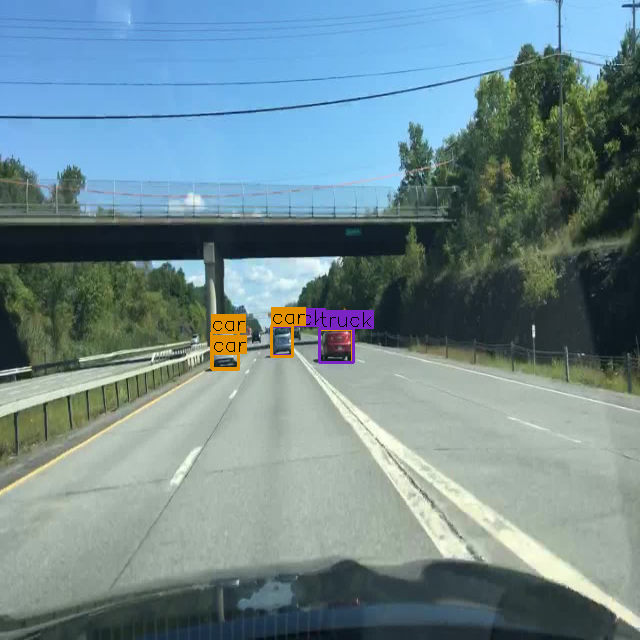

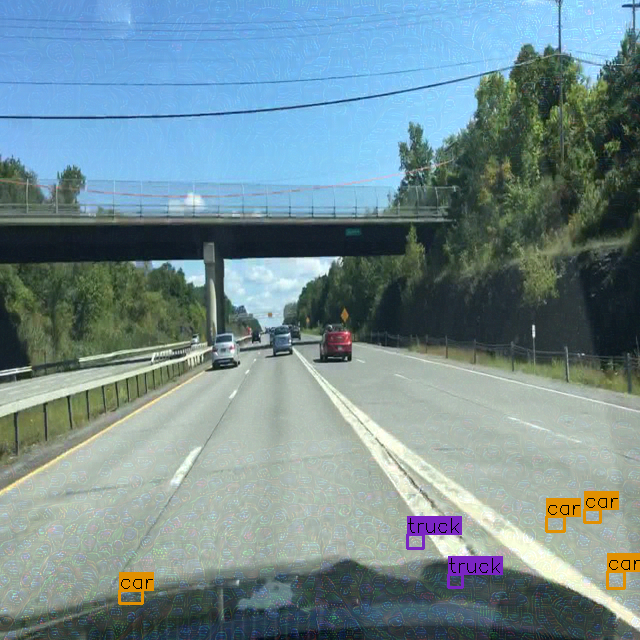

21it [00:25,  1.21s/it]


KeyboardInterrupt: 

In [22]:
# results = evaluate_results()

In [13]:
def evaluate_results(loader = test_loader, Tconf = 0.25, Tiou = 0.45, max_det_pert=300, max_det_clean=300, save_png_interval = 100):
    results_for_all_aspect_ratios = []
    for aspect_ratio, dir_name in zip(aspect_ratios, dir_names):
        print(dir_name)

        all_total_times = []
        all_nms_times = []
        all_num_bbs_before_nms = []
        all_recalls = []
        results_for_single_aspect_ratio_dir = dir_name

        for idx, (image_np, _, image_name) in tqdm(enumerate(loader)):
            if dir_name != 'no_perturbation':
                perturbed_img = perturb_img(image_name[0], aspect_ratio=aspect_ratio).unsqueeze(0)#.to("cuda:0")
            else:
                perturbed_img = image_np[0].unsqueeze(0)#.to("cuda:0")
            clean_img = image_np[0].unsqueeze(0)#.to("cuda:0")

            total_times_single_img = []
            nms_times_single_img = []

            for i in range(1):
                start_time_1 = time.time() * 1000
                output_perturbed = model(perturbed_img)[0]
                start_time_2 = time.time() * 1000
                keep_perturbed = non_max_suppression(output_perturbed, Tconf, Tiou, classes=None,max_det=max_det_pert)
                #print(len(keep_perturbed[0]))
                end_time = time.time() * 1000 
                total_time = end_time - start_time_1
                nms_time = end_time - start_time_2
                total_times_single_img.append(total_time)
                nms_times_single_img.append(nms_time)
            
            total_time = sum(total_times_single_img) / len(total_times_single_img)
            nms_time = sum(nms_times_single_img) / len(nms_times_single_img)

            output_clean = model(clean_img)[0]
            keep_clean = non_max_suppression(output_clean, Tconf, Tiou, classes=None,max_det=max_det_clean)
            classes = [int(idx) for idx in keep_clean[0][:, -1]]

            num_bbs_before_nms_mask = output_perturbed[..., 4] > Tconf 
            num_bbs_before_nms = num_bbs_before_nms_mask.sum().item()   #F(C')

            clean_xyxy = keep_clean[0][:,0:4]
            #print(clean_xyxy)

            if idx % save_png_interval == 0:
                with_bbs = add_bbs_new(clean_img, clean_xyxy, classes)
                #display(with_bbs)
                image_name = image_name[0].split('.')[0]
                output_path =  experiment_dir + '/evaluation/' + results_for_single_aspect_ratio_dir + '/' + f"{image_name}_cleanImg"
                #with_bbs.save(output_path+'.png')

            classes = [int(idx) for idx in keep_perturbed[0][:, -1]]
            perturbed_xyxy = keep_perturbed[0][:,0:4]
            
            if idx % save_png_interval == 0:
                with_bbs = add_bbs_new(perturbed_img, perturbed_xyxy, classes)
                #display(with_bbs)
                # with_bbs = add_bbs(perturbed_img, perturbed_xyxy)
                # display(with_bbs)

                output_path = experiment_dir + '/evaluation/' + results_for_single_aspect_ratio_dir + '/' + f"{image_name}_pertImg"
                #with_bbs.save(output_path+'.png')

            scaled_perturbed_xyxy = scale_bbs(orig_dims=perturbed_img.shape, target_dims=clean_img.shape, orig_xyxy = perturbed_xyxy)

            # resized_perturbed_img = F.interpolate(perturbed_img, size=(640,640), mode='bilinear', align_corners=False)
            # with_bbs = add_bbs(resized_perturbed_img, scaled_perturbed_xyxy)
            # display(with_bbs)

            box_iou_output = box_iou(clean_xyxy, scaled_perturbed_xyxy)
            
            #check if its the case that there aren't any clean detections
            #in that case, skip computing the recall
            #"the number of original objects detected in the perturbed image"
            #if there aren't any original objects, no recall can be calculated, thus we skip
            if clean_xyxy.nelement() != 0:
                #print(box_iou_output)
                #break
                recall = compute_recall(box_iou_output)
                #print(recall)
                all_recalls.append(recall)

            all_total_times.append(total_time)
            all_nms_times.append(nms_time)
            all_num_bbs_before_nms.append(num_bbs_before_nms)
            
        avg_total_time = sum(all_total_times) / len(all_total_times)
        avg_nms_time = sum(all_nms_times) / len(all_nms_times)
        avg_num_bbs_before_nms = sum(all_num_bbs_before_nms) / len(all_num_bbs_before_nms)
        avg_recall = sum(all_recalls) / len(all_recalls)

        results_for_all_aspect_ratios.append((round(avg_total_time, 1), round(avg_nms_time, 1), round(avg_num_bbs_before_nms), round(avg_recall, 3))) 
    return results_for_all_aspect_ratios

In [14]:
results = evaluate_results()

range_scaling=(1.5,2)_dimension=width


500it [16:13,  1.95s/it]


range_scaling=(0.7,0.85)_dimension=height


500it [10:55,  1.31s/it]


range_scaling=(0.6,0.75)_dimension=both


500it [07:57,  1.05it/s]


no_dimension_scaling


500it [09:28,  1.14s/it]


In [15]:
def save_csv(aspect_ratios, results, csv_file_path):
    # Create a list of dictionaries for CSV data
    csv_data = [{"aspect_ratios": pair_2, 
                "inference_time": pair_4[0], 
                "nms_time": pair_4[1], 
                "num_bbs_before_nms": pair_4[2], 
                "recall": pair_4[3]} for pair_2, pair_4 in zip(aspect_ratios, results)]

    # Save the data as CSV
    with open(csv_file_path, "w", newline="") as csv_file:
        fieldnames = ["aspect_ratios", "inference_time", "nms_time", "num_bbs_before_nms", "recall"]
        writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(csv_data)

    print(f"Data has been saved to {csv_file_path}")

In [16]:
save_csv(aspect_ratios, results, experiment_dir + 'evaluation' + '/' + 'evaluation_results.csv')

Data has been saved to /Users/coenschoof/miniconda/envs/phantomsponges/PhantomSponges/experiments/sample_experiment/evaluation/evaluation_results.csv
